In [1]:
#-- Import Modules
import os
import imp
# import cv2
import numpy as np
import rasterio
# import geopandas as gpd
import matplotlib.pyplot as plt 
import keras
from keras import backend as K
from keras.preprocessing import image
from tensorflow.python.client import device_lib
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from PIL import Image
from skimage import feature
from skimage.morphology import skeletonize
from skimage.segmentation import chan_vese
from skimage.restoration import unwrap_phase
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import binary_dilation

Using TensorFlow backend.


In [10]:
#-- Set up configurations / parameters
retrain = False # retrain previously existing model
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
n_batch = 10
n_epochs = 60
dilation_kernel = 4 #-- kernel size for increasing thickness of training labels
dilate = False
augment = False
suffix = ''
if dilate:
  suffix += '_dilated'
if augment:
  suffix += '_augmented'
aug_num = 1

## Read and plot training data on Google Drive (slant imagery data)

In [2]:
#-- Directory setup
colabdir = os.path.expanduser('~/Google Drive File Stream/My Drive/Colab Notebooks/')
ddir = os.path.expanduser('~/Google Drive File Stream/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/')
train_dir = os.path.join(ddir,'Slant_Imagery','training_data')
test_dir = os.path.join(ddir,'Slant_Imagery','testing_data')

In [58]:
#-- Get list of images
fileList = os.listdir(train_dir)
train_list = [f for f in fileList if f.endswith('_coco.tif')]
fileList = os.listdir(test_dir)
test_list = [f for f in fileList if f.endswith('_coco.tif')]

In [4]:
raster = rasterio.open(os.path.join(train_dir,train_list[15]))
im = raster.read(1) #.transpose()

In [5]:
print(np.max(im),np.min(im))

1.0 0.0


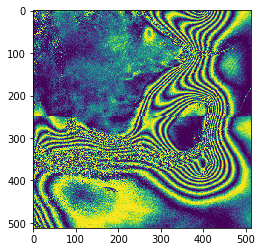

In [6]:
plt.imshow(im)
plt.show()

In [7]:
channels = raster.count
raster.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 3,
 'crs': None,
 'transform': Affine(0.0, 0.0, 0.0,
        0.0, 0.0, 0.0)}

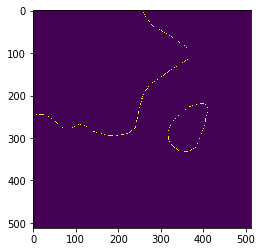

In [8]:
#-- apply dilatin to labels (thicker lines)
raster = rasterio.open(os.path.join(train_dir,train_list[15].replace('_coco.tif','_mask.tif')))
im = raster.read(1) #.transpose()

plt.imshow(im)
plt.show()

In [11]:
#-- apply dilation
"""import cv2
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(im,kernel,iterations = 1)
"""

ModuleNotFoundError: No module named 'cv2'

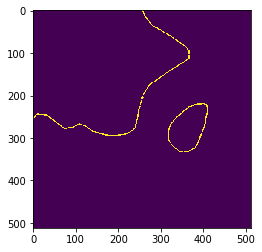

In [9]:
dilated = binary_dilation(im)

plt.imshow(dilated)
plt.show()

In [59]:
#-- Read training images
#-- Read training data with augmentation
train_imgs = np.ones((len(train_list)*aug_num,im.shape[0],im.shape[1],channels))
train_lbls = np.ones((len(train_list)*aug_num,im.shape[0],im.shape[1],1))
#i = 0
for i,f in enumerate(train_list):
    #-- read image
    raster = rasterio.open(os.path.join(train_dir,f))
    for c in range(channels):
        train_imgs[i,:,:,c] = raster.read(c+1)
        # train_imgs[i+1,:,:,c] = np.fliplr(raster.read(c+1))
        # train_imgs[i+2,:,:,c] = np.flipud(raster.read(c+1))
        # train_imgs[i+3,:,:,c] = np.fliplr(np.flipud(raster.read(c+1)))
    #-- read label
    raster = rasterio.open(os.path.join(train_dir,f.replace('coco.tif','mask.tif')))
    if dilate:
      train_lbls[i,:,:,0] = binary_dilation(raster.read(1))
    else:
      train_lbls[i,:,:,0] = raster.read(1)
    # train_lbls[i+1,:,:,0] = binary_dilation(np.fliplr(raster.read(1)))
    # train_lbls[i+2,:,:,0] = binary_dilation(np.flipud(raster.read(1)))
    # train_lbls[i+3,:,:,0] = binary_dilation(np.fliplr(np.flipud(raster.read(1))))
    #i += 4

#-- Read test data
test_imgs = np.ones((len(test_list),im.shape[0],im.shape[1],channels))
# test_lbls = np.ones((len(test_list),im.shape[0],im.shape[1],1))
for i,f in enumerate(test_list):
    #-- read image
    raster = rasterio.open(os.path.join(test_dir,f))
    for c in range(channels):
        test_imgs[i,:,:,c] = raster.read(c+1) #.transpose()
    #-- read label
    # raster = rasterio.open(os.path.join(test_dir,f.replace('coco.tif','mask.tif')))
    # test_lbls[i,:,:,0] = cv2.dilate(raster.read(1),kernel,iterations = 1) #.transpose()

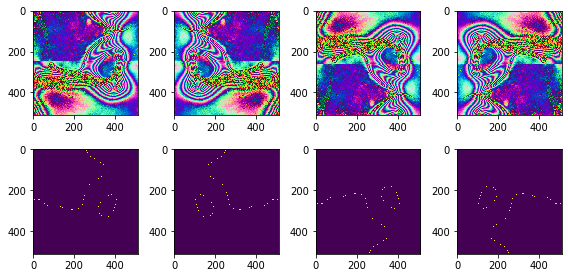

In [10]:
fig,ax = plt.subplots(2, 4,figsize=(8,4))
ax[0,0].imshow(train_imgs[60])
ax[0,1].imshow(train_imgs[61])
ax[0,2].imshow(train_imgs[62])
ax[0,3].imshow(train_imgs[63])
ax[1,0].imshow(train_lbls[60])
ax[1,1].imshow(train_lbls[61])
ax[1,2].imshow(train_lbls[62])
ax[1,3].imshow(train_lbls[63])
plt.tight_layout()
plt.show()

In [60]:
for i in range(len(train_imgs)):
    print(i,np.count_nonzero(train_imgs[i] > 1))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0


In [57]:
print(train_list[20])
print(train_list[58])

Track004964-016035-005139-016210_T080124_10_10_coco.tif
Track006888-017959-007063-018134_T062700_02_02_coco.tif


In [41]:
train_list.index('Track004964-016035-005139-016210_T080124_10_10_coco.tif')

20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


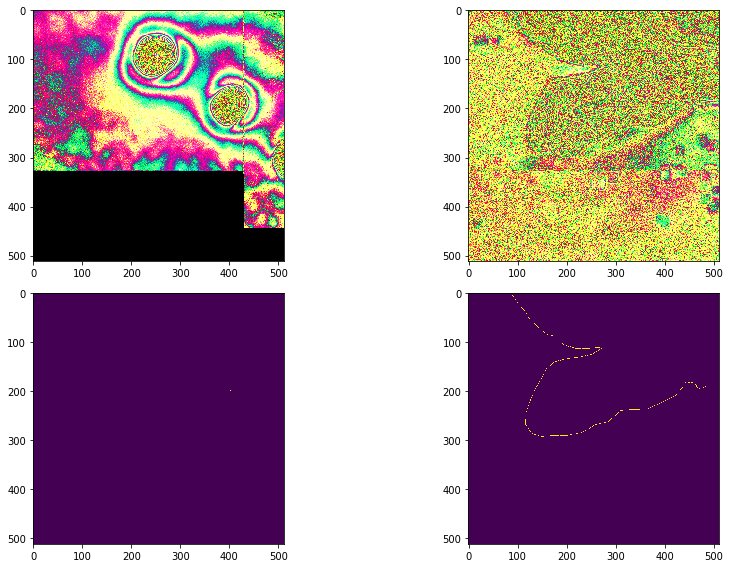

In [43]:
fig,ax = plt.subplots(2, 2,figsize=(14,8))
ax[0,0].imshow(train_imgs[20])
ax[1,0].imshow(train_lbls[20].reshape((train_lbls.shape[1],train_lbls.shape[2])))
ax[0,1].imshow(train_imgs[58])
ax[1,1].imshow(train_lbls[58].reshape((train_lbls.shape[1],train_lbls.shape[2])))
plt.tight_layout()
plt.show()

[  0   0   0 ... 443 443 443] [  8  10  26 ... 509 510 511]
[  0   0   0 ... 443 443 443] [ 72  77  78 ... 509 510 511]
[] []


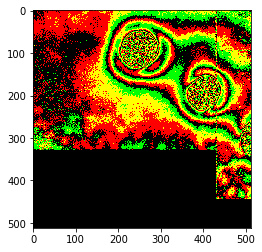

In [38]:
# print(train_imgs[20])
x1,y1 = np.nonzero(train_imgs[20,:,:,0] > 1)
x2,y2 = np.nonzero(train_imgs[20,:,:,1] > 1)
x3,y3 = np.nonzero(train_imgs[20,:,:,2] > 1)
print(x1,y1)
print(x2,y2)
print(x3,y3)
im2 = np.zeros((train_imgs.shape[1],train_imgs.shape[2],train_imgs.shape[3]))
im2[x1,y1,0] = 1
im2[x2,y2,1] = 1
plt.imshow(im2)
plt.show()

# Test already trained network

In [12]:
#-- Set up configurations / parameters
retrain = False # retrain previously existing model
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
n_batch = 10
n_epochs = 60
dilation_kernel = 4 #-- kernel size for increasing thickness of training labels
aug_str = '_augmented'

In [13]:
#-- Import U-Net model
unet = imp.load_source('unet_model',os.path.join(colabdir,'unet_model.py'))
#-- set up model
model = unet.unet_model_double_dropout(height=h,width=wi,channels=channels, 
                                       n_init=ninit,n_layers=ndown,
                                       drop=dropout_frac)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Max Number of Convlution Filters:  256

Number of Convlution Filters at the end of up segment:  32
output shape:  (?, 262144, 1)
Total Number of layers:  10


In [14]:
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'],sample_weight_mode="temporal")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
#-- checkpoint file
chk_file = os.path.join(colabdir,
                        'unet_weights_{0}init_{1}down_drop{2:.1f}{3}.h5'
                        .format(ninit,ndown,dropout_frac,aug_str))

#-- if file exists, read model from file
if os.path.isfile(chk_file):
  print('Check point exists; loading model from file.')
  #-- load weights
  model.load_weights(chk_file)
else:
  print('Model does not previously exist.')

Check point exists; loading model from file.


In [16]:
print('Model is trained. Running on Train data...')
#-------------------------------
#-- First run on training data
#-------------------------------
out_imgs = model.predict(train_imgs, batch_size=1, verbose=1)
out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])
print(out_imgs.shape)

#-- make output directory
out_dir = os.path.join(colabdir,'Train_predictions.dir',
                       'unet_weights_{0}init_{1}down_drop{2:.1f}{3}.dir'.format(
                           ninit,ndown,dropout_frac,aug_str))
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)

#-- save output images (every 4th image. Not interested in augmented cases)
for i,f in enumerate(train_list):
  im = image.array_to_img(out_imgs[4*i]) 
  im.save(os.path.join(out_dir,f.replace('coco.tif','pred.png')))

Model is trained. Running on Train data...
624/624 [==============================] - 758s 1s/step
(624, 512, 512, 1)


In [17]:
#-------------------------------
#-- Run on test data
#-------------------------------
out_imgs = model.predict(test_imgs, batch_size=1, verbose=1)
out_imgs = out_imgs.reshape(out_imgs.shape[0],h,wi,out_imgs.shape[2])
print(out_imgs.shape)

#-- make output directory
out_dir = os.path.join(colabdir,'Test_predictions.dir',
                       'unet_weights_{0}init_{1}down_drop{2:.1f}{3}.dir'.format(
                           ninit,ndown,dropout_frac,aug_str))
if (not os.path.isdir(out_dir)):
  os.mkdir(out_dir)

#-- save output images
for i,f in enumerate(test_list):
  im = image.array_to_img(out_imgs[i]) 
  im.save(os.path.join(out_dir,f.replace('coco.tif','pred.png')))

34/34 [==============================] - 46s 1s/step
(34, 512, 512, 1)


# Making training masks

In [72]:
#-- label the GL in the original image
for i in range(len(imgs)):
    ii,jj = np.nonzero(lbls[i])
    for c in range(channels):
        imgs[i,ii,jj,c] = 0.

#-- save figures to trainig folder
out_dir = os.path.expanduser('~/GL_learning_data/slant_data/trainig_data')
for i in range(len(fileList)):
    try:
        plt.imsave(os.path.join(out_dir,fileList[i].replace('_coco.tif','.png')), imgs[i])
    except:
        print(fileList[i])
        continue

in_dir = os.path.expanduser('~/Documents/GL labels')
gdrive = os.path.expanduser('~/Google Drive File Stream/My Drive')
flist = os.listdir(in_dir)
for f in flist:
    if os.path.exists(os.path.join(gdrive,'GL_Learning','GL_learning_data','slant_data','trainig_data',f)):
        print(f)
        os.remove(os.path.join(gdrive,'GL_Learning','GL_learning_data','slant_data','trainig_data',f))
    else:
        print('Already deleted %s'%f)

# Load plot directly into arrays using npy

In [44]:
#-- Load data
X_train=np.load(os.path.join(train_dir,'X_train.npy'))
Y_train=np.load(os.path.join(train_dir,'Y_train.npy'))
# X_test=np.load(os.path.join(test_dir,'X_test.npy'))
# Y_test=np.load(os.path.join(test_dir,'Y_test.npy'))

In [64]:
for i in range(58):
    print(i,np.count_nonzero(X_train[i]- train_imgs[i]))
for i in range(58,len(X_train)-1):
    print(i,np.count_nonzero(X_train[i+1]- train_imgs[i]))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0


TypeError: Invalid shape (512, 512, 1) for image data

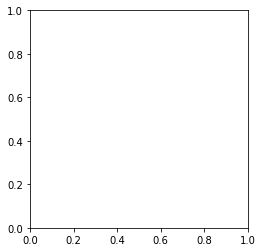

In [52]:
dilated = binary_dilation(Y_train[58])

plt.imshow(dilated)
plt.show()

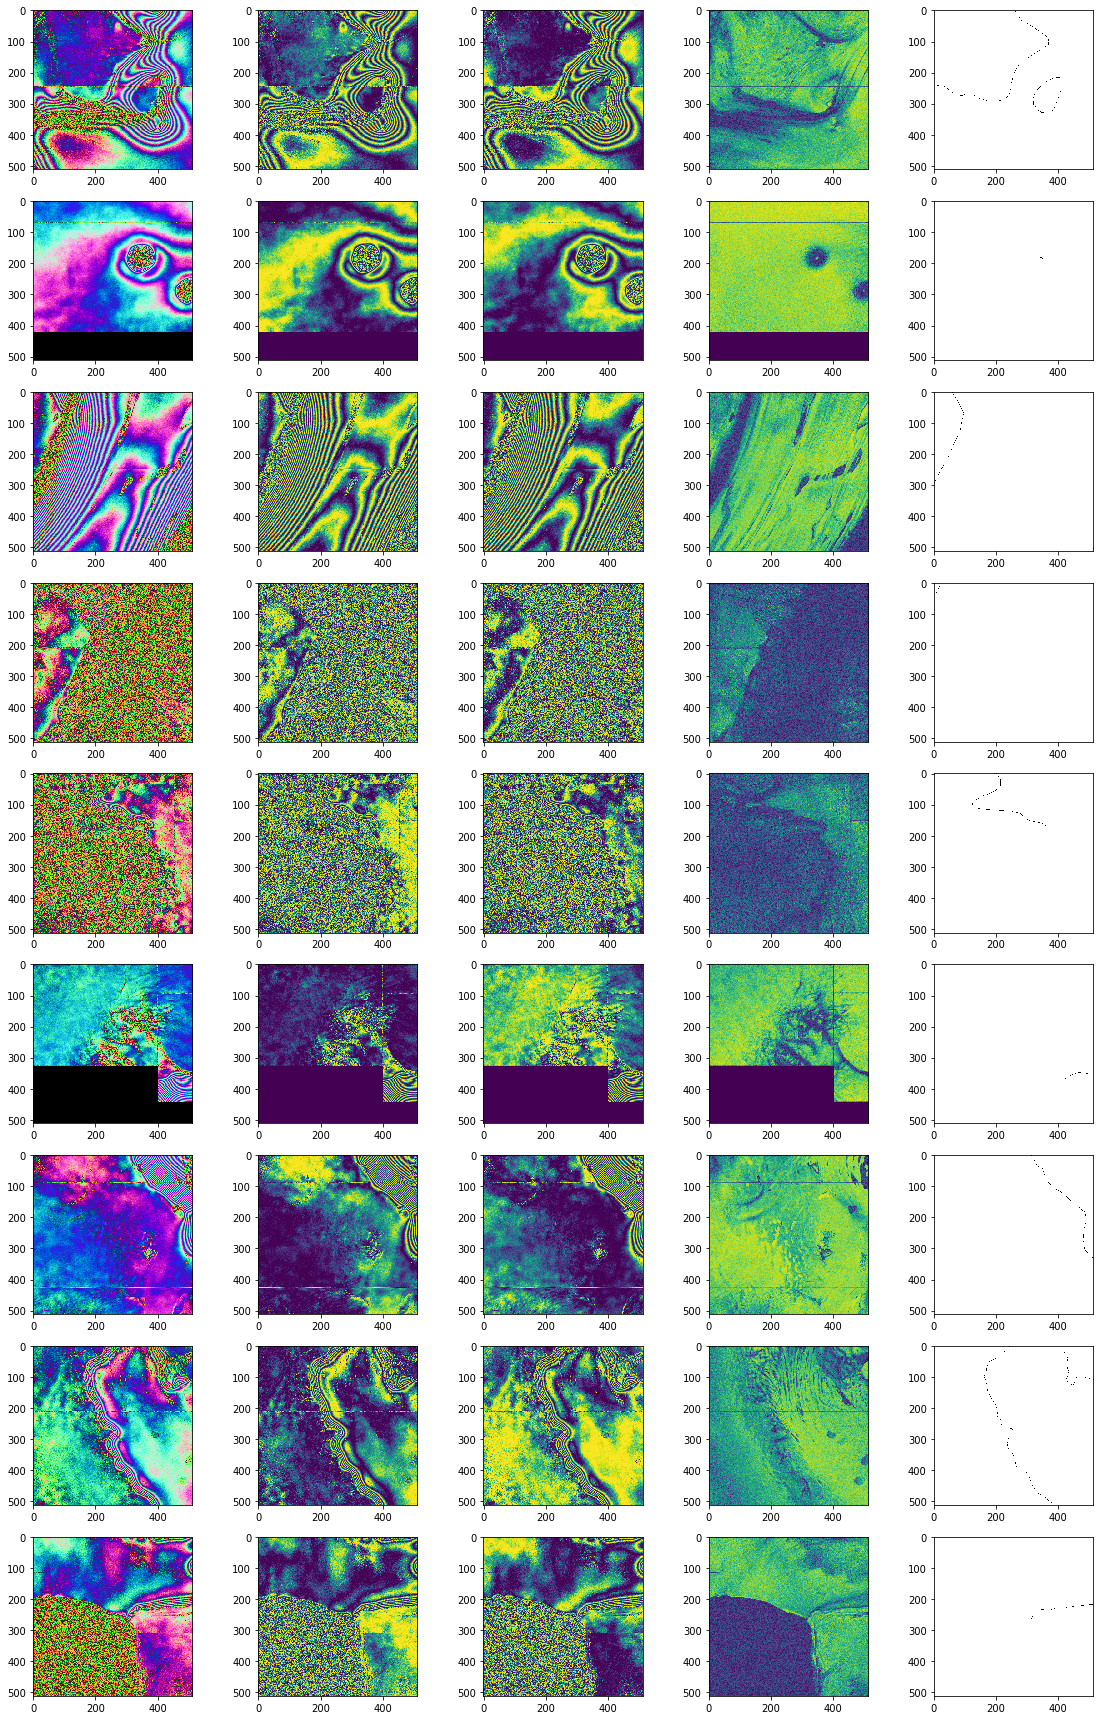

In [48]:
iilist = [15,0,14,6,7,9,13,21,23]
fig,ax = plt.subplots(len(iilist), 5,figsize=(16,24))
for i,j in enumerate(iilist):
    ax[i,0].imshow(X_train[j])
    ax[i,1].imshow(X_train[j,:,:,0])
    ax[i,2].imshow(X_train[j,:,:,1])
    ax[i,3].imshow(X_train[j,:,:,2])
    ax[i,4].imshow(Y_train[j,:,:,0],cmap='binary')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


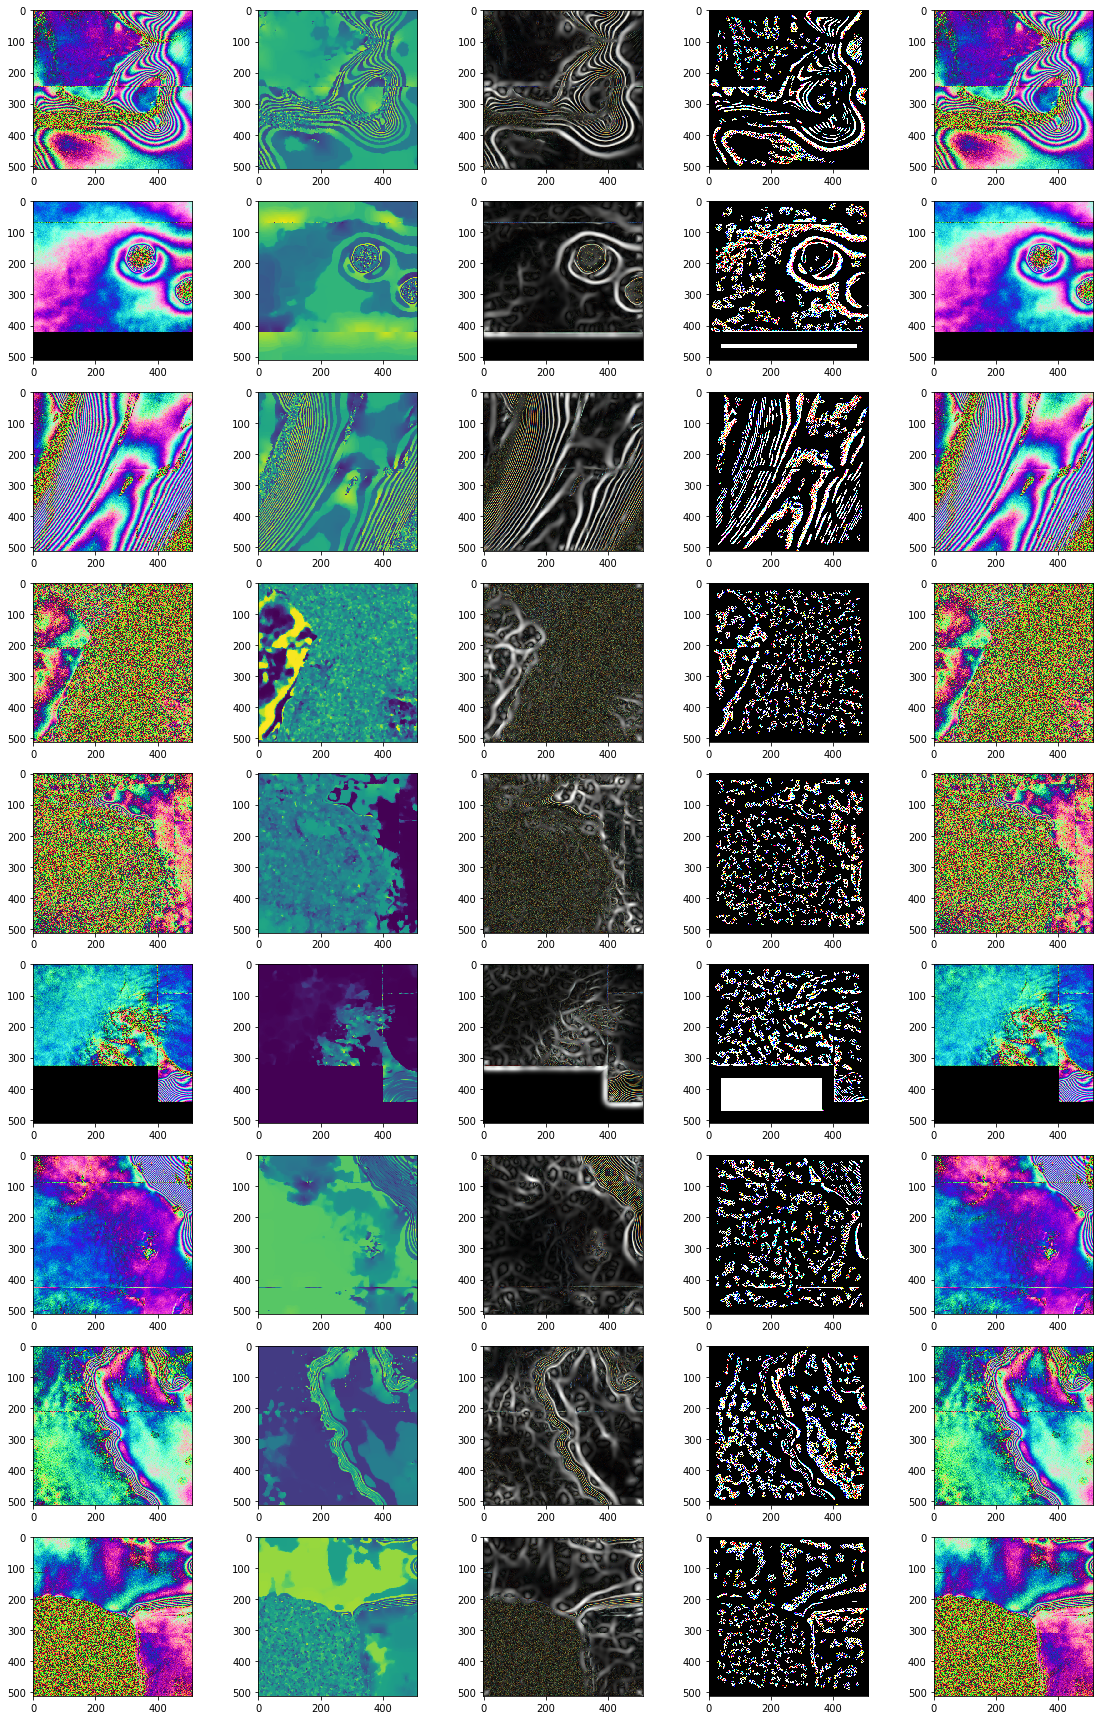

In [22]:
iilist = [15,0,14,6,7,9,13,21,23]
fig,ax = plt.subplots(len(iilist), 5,figsize=(16,24))
for i,j in enumerate(iilist):
#     edges1 = feature.canny(X_train[j,:,:,0])
#     edges1 = skeletonize(X_train[j,:,:,0])
    edges1 = chan_vese(X_train[j,:,:,0], mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)[1]
    edges2 = meijering(X_train[j])
#     edges3 = frangi(X_train[j])
    edges3 = hessian(X_train[j])
    image_unwrapped = unwrap_phase(X_train[j])
    ax[i,0].imshow(X_train[j])
    ax[i,1].imshow(edges1)
    ax[i,2].imshow(edges2)
    ax[i,3].imshow(edges3)
#     ax[i,4].imshow(Y_train[j,:,:,0],cmap='binary')
    ax[i,4].imshow(image_unwrapped)
plt.tight_layout()
plt.show()

In [6]:
for i in range(len(X_train)):
    fig,ax = plt.subplots(1, 2,figsize=(16,10))
    ax[0].imshow(X_train[i])
    ax[0].set_title('Image')
    ax[1].imshow(Y_train[i,:,:,0],cmap='binary')
    ax[1].set_title('Training Label (black dots=GL)')
    for j in range(2):
        ax[j].get_xaxis().set_ticks([])
        ax[j].get_yaxis().set_ticks([])
    plt.savefig(os.path.join(train_dir,'image%i.png'%i),format='PNG')
    plt.close(fig)

## Read training data with shapefiles provided by Bernd

In [14]:
dat_dir = os.path.expanduser('~/GL_learning_data/Test_Training/2018_Track069')
#-- archives to read
fileList = []
for i in range(1,7):
    fileList += os.listdir(os.path.join(dat_dir,'Archive_%02i'%i))
tif_list = [f for f in fileList if f.endswith('.tif')]
print(len(tif_list))

92


In [15]:
raster = rasterio.open(os.path.join(dat_dir,'Archive_01',tif_list[0]))
im = raster.read(1).transpose()
print(np.min(im),np.max(im))


0 255


In [16]:
h,w = im.shape
xs = np.zeros((h,w))
ys = np.zeros((h,w))
for i in range(h):
    for j in range(w):
         xs[i,j],ys[i,j]= raster.transform * (i,j)

In [17]:
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 2730,
 'height': 3610,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3031'),
 'transform': Affine(100.0, 0.0, -1641300.0,
        0.0, -100.0, -839700.0)}

In [18]:
#-- read shapefile
gdf = gpd.read_file(os.path.join(dat_dir,'Archive_01',tif_list[0].replace('.tif','.shp')))
gdf

ID      Sensor Track  Date_1  Date_2  Date_3  Date_4 Orbit_1 Orbit_2  \
0      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
1      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
2     66  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
3      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
4      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
5   None  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
6      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
7      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
8      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
9      0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
10     0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
11     0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
12     0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   
13     0  Sentinel_1   069  180317  180323  180323  180329  010070  021141   

   Orbit_3 Orbit_4   Time_1   Time_2  \
0   021141  010245  T110447  T110529   
1   021141  010245  T110447  T110529   
2   021141  010245  T110447  T110529   
3   021141  010245  T110447  T110529   
4   021141  010245  T110447  T110529   
5   021141  010245  T110447  T110529   
6   021141  010245  T110447  T110529   
7   021141  010245  T110447  T110529   
8   021141  010245  T110447  T110529   
9   021141  010245  T110447  T110529   
10  021141  010245  T110447  T110529   
11  021141  010245  T110447  T110529   
12  021141  010245  T110447  T110529   
13  021141  010245  T110447  T110529   

                                             geometry  
0   LINESTRING (-1516012.561024584 -917211.0644452...  
1   LINESTRING (-1441367.955907787 -914895.2830214...  
2   LINESTRING (-1435657.193950057 -946237.0238445...  
3   LINESTRING (-1457241.176152504 -945652.4576599...  
4   LINESTRING (-1461108.306297109 -991068.7535442...  
5   LINESTRING (-1461917.7056297 -1000826.51216492...  
6   LINESTRING (-1445774.685607453 -1040891.779128...  
7   LINESTRING (-1458410.308521803 -1030414.554434...  
8   LINESTRING (-1457713.325763181 -1011348.703488...  
9   LINESTRING (-1463154.28794338 -987381.48991798...  
10  LINESTRING (-1442806.888054615 -966719.3236220...  
11  LINESTRING (-1421177.93922258 -977376.41483455...  
12  LINESTRING (-1415197.377487319 -1000084.562776...  
13  LINESTRING (-1417490.675596328 -1020949.078905...

In [19]:
gdf.crs

{'init': 'epsg:3031'}

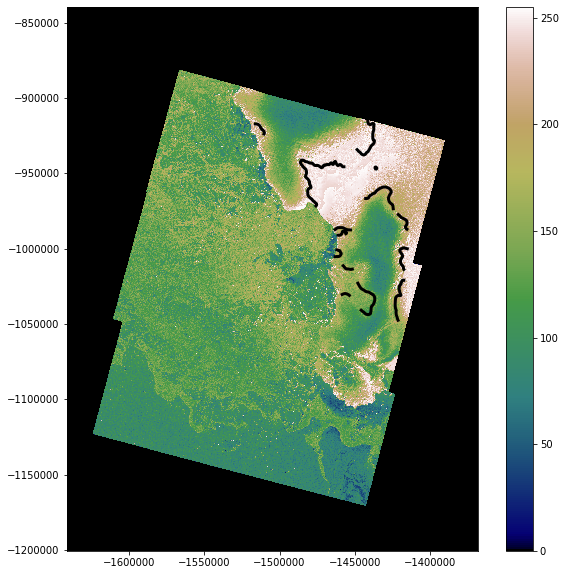

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt_im = ax.pcolormesh(xs,ys,im,cmap='gist_earth')
fig.colorbar(plt_im, ax=ax)
for i in range(len(gdf['geometry'])):
    x,y = gdf['geometry'][i].coords.xy
    ax.plot(x,y,color='k',linewidth=3.0)
ax.set_aspect('equal')
plt.show()

In [10]:
#-- Compare dimensions of images in different folders
im = {}
for i in range(1, 7):
    fileList = os.listdir(os.path.join(dat_dir,'Archive_%02i'%i))
    tif_list = [f for f in fileList if f.endswith('.tif')]
    raster = rasterio.open(os.path.join(dat_dir,'Archive_%02i'%i,tif_list[0]))
    im[i] = raster.read(1).transpose()
    print(im[i].shape)

(2730, 3610)
(2476, 2955)
(2726, 3590)
(2480, 2980)
(2470, 2955)
(2390, 2885)


# Experimenting with new geocoded data

In [2]:
#-- Directory setup
ddir = os.path.expanduser('~/GL_learning_data/geocoded_v1/')
img_dir = os.path.join(ddir,'cocotile_withoutnull_v1')
lbl_dir = os.path.join(ddir,'delineationtile_withoutnull_v1')

In [3]:
#-- Get list of images
fileList = os.listdir(img_dir)
train_list = [f for f in fileList if f.endswith('.tif')]
train_list

['coco_gl_007_180921-180927-180927-181003_012808-023879-023879-012983_T050840_T050926_x1284_y0512_DIR01.tif',
 'coco_gl_069_181206-181212-181218-181224_013920-024991-014095-025166_T110549_T110549_x1536_y2048_DIR11.tif',
 'coco_gl_069_181112-181118-181118-181124_013570-024641-024641-013745_T110456_T110538_x1536_y0440_DIR10.tif',
 'coco_gl_007_180530-180605-180605-180611_022129-011233-011233-022304_T050919_T050834_x1382_y0137_DIR00.tif',
 'coco_gl_007_180903-180909-180909-180915_023529-012633-012633-023704_T050925_T050840_x1284_y0047_DIR00.tif',
 'coco_gl_007_180816-180822-180822-180828_012283-023354-023354-012458_T050839_T050924_x1796_y1024_DIR01.tif',
 'coco_gl_007_181214-181220-181220-181226_014033-025104-025104-014208_T050814_T050900_x1792_y1536_DIR01.tif',
 'coco_gl_007_171231-180106-180112-180118_008958-020029-009133-020204_T050832_T050832_x1536_y0512_DIR11.tif',
 'coco_gl_007_180301-180307-180307-180313_009833-020904-020904-010008_T050806_T050851_x0866_y1191_DIR00.tif',
 'coco_gl_

In [5]:
raster = rasterio.open(os.path.join(img_dir,train_list[0]))
im = raster.read(1)

In [31]:
channels = raster.count
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3031'),
 'transform': Affine(100.0, 0.0, -1353400.0,
        0.0, -100.0, -1026600.0)}

In [37]:
#-- Read training images
#-- Read training data with augmentation
train_imgs = np.ones((len(train_list),im.shape[0],im.shape[1]),dtype=np.complex_)
train_lbls = np.ones((len(train_list),im.shape[0],im.shape[1]))
for i,f in enumerate(train_list[:30]):
    #-- read image
    raster = rasterio.open(os.path.join(img_dir,f))
    train_imgs[i,:,:] = raster.read(1)
    #-- read label
    raster = rasterio.open(os.path.join(lbl_dir,f.replace('coco','delineation')))
    train_lbls[i,:,:] = raster.read(1)

In [43]:
train_imgs[15,:,:]

array([[ 0.22924046+0.034245j  ,  0.04888942-0.11703774j,
         0.2448929 +0.0873475j , ...,  0.40070859-0.09889634j,
         0.4096581 -0.57233149j,  0.46336329-0.08233491j],
       [ 0.2233533 -0.03740567j,  0.18395281+0.39694756j,
        -0.18961619+0.16936174j, ...,  0.10182047+0.22673036j,
         0.35831997-0.0721049j ,  0.06101906+0.12933607j],
       [ 0.11133914-0.07818058j,  0.33622998+0.03150125j,
         0.46089622+0.32466468j, ...,  0.41232672+0.02514027j,
         0.24118969+0.33090436j,  0.92292655-0.34582618j],
       ...,
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j       

In [54]:
np.max(train_imgs[:,:,:].real)

19.561128616333008

In [55]:
np.min(train_imgs[:,:,:].real)

-20.920312881469727

In [56]:
print(np.max(train_imgs[:,:,:].imag),np.min(train_imgs[:,:,:].imag))

20.13637924194336 -21.63197898864746


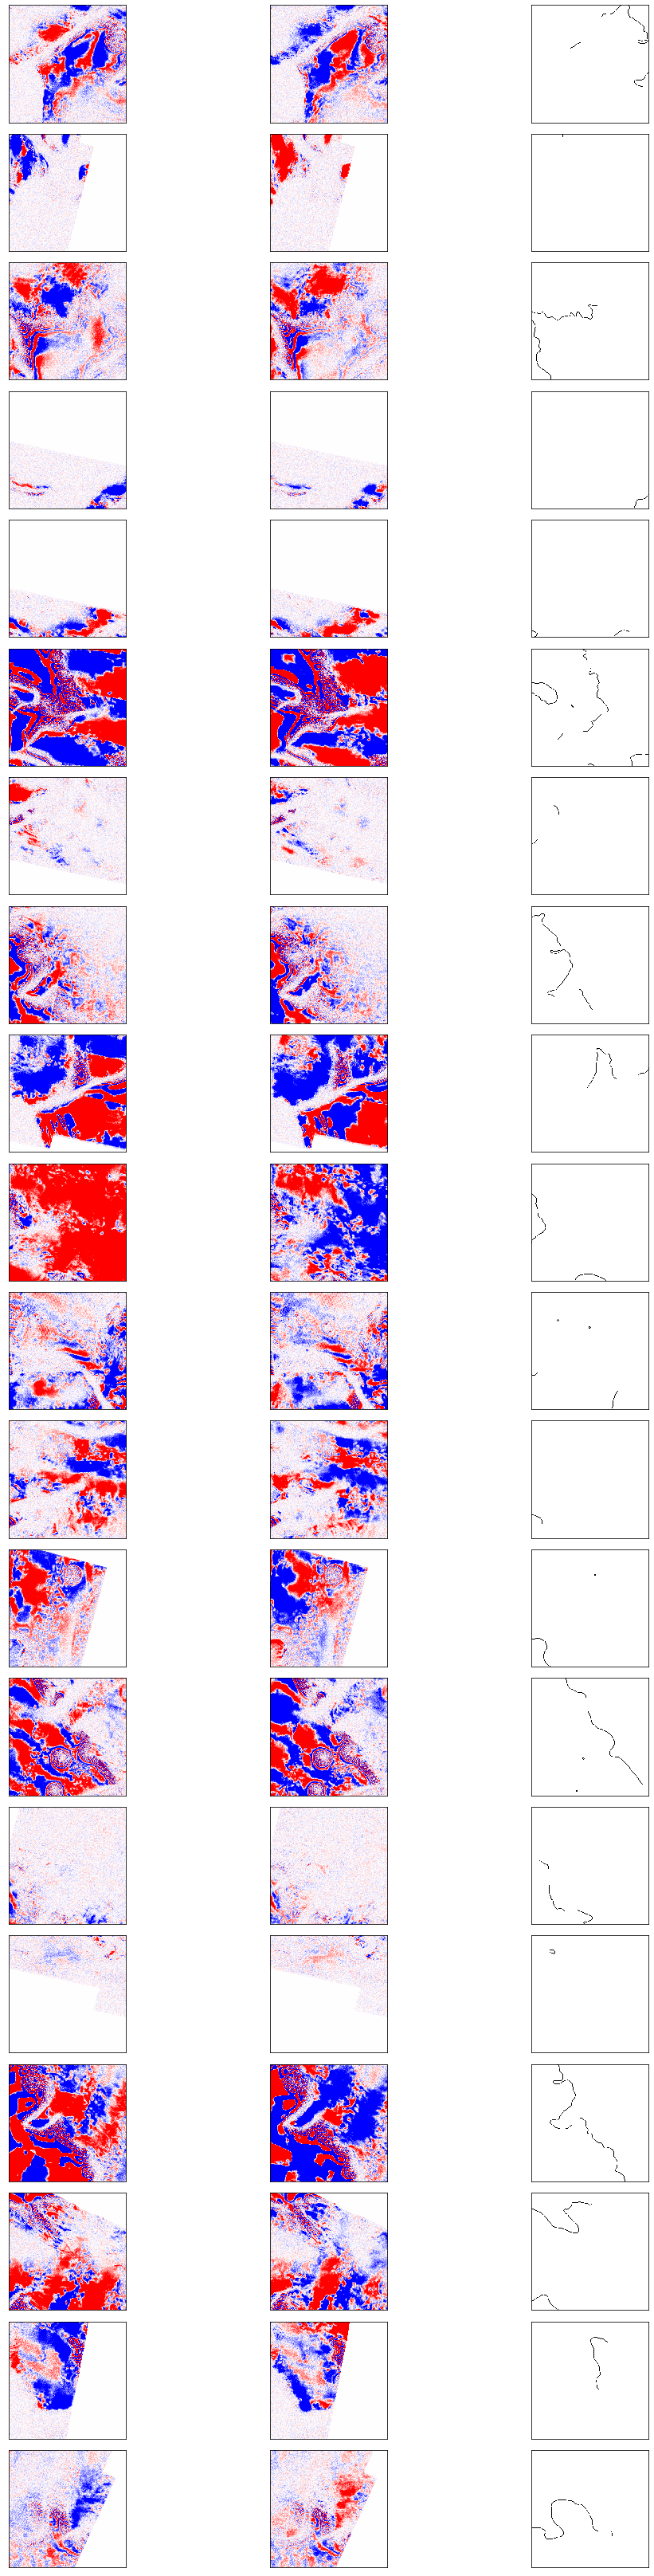

In [59]:
iilist = np.arange(20)
fig,ax = plt.subplots(len(iilist),3,figsize=(16,45))
for i,j in enumerate(iilist):
    ax[i,0].imshow(train_imgs[j,:,:].real,cmap='bwr',vmin=-2,vmax=2)
    ax[i,1].imshow(train_imgs[j,:,:].imag,cmap='bwr',vmin=-2,vmax=2)
    ax[i,2].imshow(binary_dilation(train_lbls[j,:,:]),cmap='binary')
    for k in range(3):
        ax[i,k].get_xaxis().set_ticks([])
        ax[i,k].get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()

{'driver': 'GTiff',
 'dtype': 'complex64',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3031'),
 'transform': Affine(100.0, 0.0, -1579400.0,
        0.0, -100.0, -712400.0)}

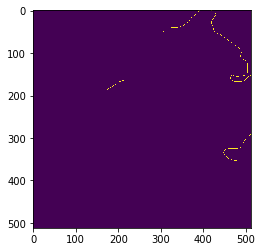